## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [104]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [105]:
#reading the main csv file and storing it into the variable df
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [106]:
#to get the number of rows in our DataFrame
df.shape[0]

294478

c. The number of unique users in the dataset.

In [107]:
#to get the unique users in our DataFrame
df.user_id.nunique()

290584

d. The proportion of users converted.

In [108]:
#convertion rate in our DataFrame
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [109]:
#wrong data places in our DataFrame
len(df[(df['group'] == 'treatment') != (df['landing_page'] == 'new_page')])

3893

f. Do any of the rows have missing values?

In [110]:
#here are provided two ways for checking our missing values in rows
df.info()
df.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [111]:
#filtering the wrong values for treatment and getting the index for the row and the column
false_treatment = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index
#filtering the wrong values for control and getting the index for the row and the column
false_control = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index

##### note : we took the index for each filter to helps us perform the .drop() function 

In [112]:
# dropping the wrong treatment values by using .drop function 
df.drop(false_treatment, inplace =True)
# dropping the wrong conrtol values by using .drop function 
df.drop(false_control, inplace =True)

In [113]:
#storing the new changes into (df2) by just taking a copy from (df) 
df2 = df.copy()
df2.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [114]:
#checking if there any wrong values in treatment group __ this should print false
print(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]['landing_page'].any())

print('---------------------------------------------------------')
#checking if there any wrong values in control group __ this should print false
print(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]['landing_page'].any())

False
---------------------------------------------------------
False


In [115]:
# Double Check all of the correct rows were removed - this should be 0
print(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])

print('---------------------------------------------------------')

print(df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0])


0
---------------------------------------------------------
0


In [116]:
#getting the number of rows in the new DataFrame
df2.shape[0]

290585

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [117]:
#getting the unique number of users in the new DataFrame
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [118]:
#getting the number of duplicated users 
print(sum(df2.user_id.duplicated()))

#getting the index of the duplicated user
df2[df2.user_id.duplicated() == True].index

1


Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [119]:
#displaying the information of the duplicated user
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [120]:
#dropping the duplicated user
df2.user_id.drop_duplicates(inplace = True)

In [121]:
#checking of the duplicated user was successfully deleted -- this should print false
df2.user_id.duplicated().any()

False

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [122]:
#the mean for the convertion in our DataFrame  
convert_rate = len(df2[df2['converted'] == 1])/df2.converted.count()
convert_rate

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [123]:
#conversion probability for the control group
len(df2[(df2['converted'] == 1) & (df2['group'] == 'control')])/len(df2[df2['group'] == 'control']['converted'])       

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [124]:
#conversion probability for the treatment group
len(df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')])/len(df2[df2['group'] == 'treatment']['converted'])

0.11880724790277405

d. What is the probability that an individual received the new page?

In [125]:
#probability for recieving new page
len(df2[df2['landing_page'] == 'new_page'])/df.shape[0]

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### The conclusion was that the new treatment `lead to more conversions` and the above calculations supports that conclusion :
1. in `a` the conversion rate regardless the page the users recieve is `0.1196` which isn't that much
2. in `b` the probability of a control user change or "convert" to the new page is `0.1204` which is very low probability but still leads more than part `c`
3. in `c` the probability of a treatment user change to the old page is `0.1188` which is less likely that the treatment individual go back to the old page 
4. in `d` we concluded that each individual in an experiment group (`control` or `treatment`) have nearly the same chance of getting either new page or old page


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

__--ANSWER--__
$$H_0: p_{old} >= p_{new}$$

$$H_1: p_{new} > p_{old}$$

where the $H_0$ and $H_1$ is the null and alternative respectively

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [126]:
#convert rate under the null this cell and the below cell will have the same value since the rates are equal  
#regardless of the page
convert_rate_new = len(df2[(df2['converted'] ==1)])/df2.shape[0]
convert_rate_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [127]:
convert_rate_old = len(df2[(df2['converted'] ==1)])/df2.shape[0]
convert_rate_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [128]:
#number of rows for individuals in treatment group
n_new = len(df2.query('group == "treatment"')['user_id'])
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [129]:
#number of rows for individuals in control group
n_old = len(df2.query('group == "control"')['user_id'])
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [130]:
#simulating transactions (random choice) | note : I selected random.choice because it provides a parameter for 
#the probabilty
new_page_converted = []
for i in range(n_new):      #array between 0,1 #to allow replacements  # probability rate 
    random = np.random.choice(np.arange(0,2) , replace = True , p=[(1-convert_rate_new) , convert_rate_new])
    new_page_converted.append(random)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [131]:
#same as the above cell the difference here that the transactions and convertion rate was for the old page
old_page_converted = []
for i in range(n_old):
    random = np.random.choice(np.arange(0,2) , replace = True , p=[(1-convert_rate_old) , convert_rate_old])
    old_page_converted.append(random)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [132]:
#in part e and f we simulated the transactions to get the difference in means and this cell for doing that 
np.array(new_page_converted).mean() - np.array(old_page_converted).mean()

0.0020068299945636275

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [133]:
#bootstrapping 
p_diffs = [] 
for i in range(10000):
        boot_new_page_converted = np.random.choice(np.arange(0,2), replace = True , size = n_new , p=[(1-convert_rate_new),convert_rate_new])
        boot_old_page_converted = np.random.choice(np.arange(0,2), replace = True , size = n_old ,p=[(1-convert_rate_old) ,convert_rate_old])
        p_diffs.append(boot_new_page_converted.mean() - boot_old_page_converted.mean())
#converting p_diffs into a NumPy array 
p_diffs = np.array(p_diffs)

#### Limitations :
I tried to make `boot_new_page_converted` and `boot_old_page_converted` as arrays and append to them __np.random.choice__ but it seems to take very very much time i'm talking like hours or maybe days so instead I tried to use them as temporary variables and it seems to take less than two minutes 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

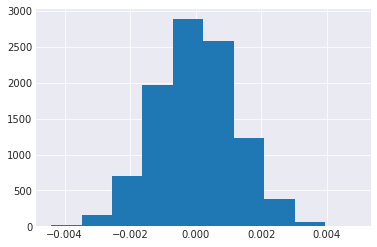

In [134]:
#plotting p_diffs (histogram plot)
sns.set_style('darkgrid')
plt.hist(p_diffs)
plt.show()

__--ANSWER--__ : the plot was as I expected to be since the Central limit Theorem states that with a 
large number of samples (in our case was `10000`) we should get a __Normally distributed__ histogram

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [135]:
#getting the observed difference 
treat_diff = len(df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)])/ len(df2[df2['group'] == 'treatment'])
cont_diff = len(df2[(df2['group'] == 'control') & (df2['converted'] == 1)])/ len(df2[df2['group'] == 'control'])
obs_diff = treat_diff - cont_diff 
obs_diff

-0.0015790565976871451

In [136]:
#calculating p value
(p_diffs > obs_diff).mean()

0.90569999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

__--ANSWER--__ : the value that I just computed called the `p value` and this value provides us with the information on whether to reject the null or fail to reject the null .

if the `p value` was greater than the `type I` error we come with the decision to __Fail To Reject The Null__ which exactly our case 
but if the `p value` was less than `type I` error we can say that the the value is statistical significance and we __Reject The Null__ 

We can stop testing after bootstrapping for 10000 iterations and come with a final result after that. 

It's much better to have a fine number of iterations to get the right p value as you can notice the difference between the calculations done in part `e` through part `g` with the calculation done in part `h` (the bootstarpping) .

After performing tests multiple time we can get the right p value

#### Glossary:
1. with the above calculations we come with that our old page is better than the new page
2. with a high number of tests we can come with the right conclusion

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [137]:
#getting number of conversion in each page
convert_old = len(df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)])
convert_new = len(df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)])
#getting the number of rows associated with each page
n_old = len(df2[df2['landing_page'] == 'old_page'])
n_new = len(df2[df2['landing_page'] == 'new_page'])


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [138]:
#number of successfull conversions 
count = np.array([convert_old , convert_new])
#number of observations
nobs = np.array([n_old , n_new])
#since our alternative hypothesis states that p_new > p_old so p_old is smaller than p_new
#the alternative value below should be 'smaller'                      
z_score , p_value = proportions_ztest(count , nobs ,alternative = 'smaller')
z_score , p_value

(1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

__--ANSWER--__ : z score is (one of the measurements to determine whether to reject or fail to reject the null)
since our z score is positive that is an indication that the value is above the mean and we come to __Fail To Reject The Null__.

the p value is the value that determines whether to accept or reject the null after the above calculations we come to __Fail To Reject The Null__.

These findings matches with parts `j` and `k`


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

__--ANSWER--__  : The regression model needed is **Logistc Regression** since it's between to values `(yes or no) `
or you can say `between 0 and 1`

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [139]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [140]:
#creating an intercept column
df2['intercept'] = 1
#getting the dummy variables for the group column 
df2[['control' , 'treatment']] = pd.get_dummies(df2['group'])

In [141]:
#dropping the control column to be our baseline
df2.drop('control' ,axis = 1 , inplace = True)
#since we need only 1 for treatment and 0 for control we need only the treatment column 
#and as needed above we are going to change it's name into ab_page
df2.rename(columns = {'treatment' : 'ab_page'} , inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [142]:
#below the code for fitting the Logistic Regression model
mod = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [143]:
#summary for the Regression Model
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-30 22:29 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

In [144]:
#to interpret the ab_page column we need to divide 1 by the exponential value of ab_page 
1/np.exp(-0.0150)

1.0151130646157189

#### In the above Logistic Regression model I did the following :

1. I added an intercept column 
2. I added the dummy variables in the group column to perdict the number of individuals who will convert from either `new_page` or `old_page`
3. I deleted the control column since we don't need it and also to make the martix full rank which allow us to predict the convert rate __Control dummy variable was the baseline__

#### Interpreting The Results Of The Model :

1. if an individual recieved `control` he's 1.015 times more likely to convert than if he recieved `treatment`
2. since the p_value of the `ab_page` is `0.1897` not equal to `0` we come to __Fail To Reject The Null__

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

__--ANSWER--__ : 
the p value that associated with ab_page is `0.1879` and the p value in __Part II__ is `0.9` they differ because in Logistec Regression each coefficient is dependent on other variables 

since p_value is : `0.1897` which doesn't equal to 0 so we can say that it isn't a statistical significance and we come to ` fail to reject the null` 

since we dealing with __Logistic Regression__ model which is either true or false so the null and alternative hypothesis will be :
$$H_0:  p_{new} - p_{old} = 0 $$ 

$$H_1: p_{new}  - p_{old} \neq 0 $$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

__--ANSWER--__ : It will be better to consider another factors so you can know exactly why the individual will convert or will not 
and does this conversion helps him or not it's always better to add helpful factors in your model

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [145]:
#reading the countries.csv and store it in df3
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [146]:
#to know how many variables we need
df3.country.unique() 

array(['UK', 'US', 'CA'], dtype=object)

In [147]:
#joining the original DataFrame with the countries DataFrame (df3)
df2 = df2.join(df3 , rsuffix = '_country')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,user_id_country,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,834778.0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,928468.0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,822059.0,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,711597.0,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,710616.0,UK


In [148]:
#getting the dummy variabels for the country column
df2[['UK' , 'US' , 'CA']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,user_id_country,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,834778.0,UK,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,928468.0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,822059.0,UK,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,711597.0,UK,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,710616.0,UK,0,1,0


In [149]:
#code for fitting the Logistic Regression model using the CA dummy variable as the baseline
mod = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page' , 'UK' , 'US']])
res = mod.fit()
#providing a summary for the results
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-30 22:29 AIC:              212783.3019
No. Observations:   290585           BIC:              212825.6205
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9891    0.0089  -224.0204  0.0000  -2.0065  -1.9717
ab_page      -0.0150    0.0114    -1.3091  0.1905  -0.0374   0.0074
UK           -0.0258    0.0269    -0.9589  0.3376  -0.0785   0.0269
US            0.0065    0.0134     0.4838  0.6285  -0.0197   0.0327
==================================================================

"""

In [150]:
#to interpret UK coefficient
1/np.exp(-0.0258)

1.026135700809198

In [151]:
#to interpret US coefficient | note : since it's a positive number we don't need to divide it by 1 
np.exp(0.0065)

1.0065211708453077

## In the above Logistec Regression model I did the following :
1. I read the `conutries.csv` file and store it in __df3__
2. I used the `.join` function to merge between the original DataFrame `df2` and the new DataFrame `df3`
3. after the join I created the dummy variables using `CA` as the baseline 

### Interpretation for the above Logistec Regression model :
1. looks like individuals from `CA` are 1.03 times more likely to convert than if they were from `UK`
2. looks like individuals from `CA` are 1.01 times more likely to convert than if they were from `US`

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [152]:
#providing the interaction between the ab_page column and countries dummy variable
df2['US_ab_page'] = df2['US'] * df2['ab_page']
df2['UK_ab_page'] = df2['UK'] * df2['ab_page']

In [153]:
#code for fitting the Logistic Regression model for the interaction
mod = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page' , 'UK' , 'UK_ab_page' , 'US' , 'US_ab_page']])
res = mod.fit()
#providing a summary for the results
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-30 22:29 AIC:              212784.9096
No. Observations:   290585           BIC:              212848.3875
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9859    0.0096  -206.7920  0.0000  -2.0047  -1.9670
ab_page      -0.0215    0.0136    -1.5817  0.1137  -0.0482   0.0052
UK           -0.0675    0.0385    -1.7528  0.0796  -0.1430   0.0080
UK_ab_page    0.0825    0.0538     1.5339  0.1251  -0.0229   0.1880
US            0.0013    0.0188     0.0669  0.9467  -0.0356   0.0381
US_ab_page    0.0105    0.0267     0.3925  0.6947  -0.0419   0.0629
==================================================================

"""

## In the above Logistec Regression model I did the following :
1. Created additional columns for the interaction between pages and countries dummy variables 
2. I fitted the Logistic Regression model
3. the summary for the Regression model was provided 

### Interpretation for the above Logistec Regression model :

1. First we concluded that the countries columns didn't make any difference with the conversion of individual  

4. looks like our new countries columns ins't significance since the `p value` assosiated with them doesn't equal to `0` we come to __Fail To Reject The Null__

## Conclusion :
After viewing our Regression models and performing A/b tests we observed that the company should stick to the old page 

In [154]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0